# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train.groupby('Sex')['Pclass'].value_counts(normalize=True)

Sex     Pclass
female  3         0.458599
        1         0.299363
        2         0.242038
male    3         0.601386
        1         0.211438
        2         0.187175
Name: Pclass, dtype: float64

### Фичи

чтобы одинаковым образом обработать train и test и не дублировать все операции 2 раза, соединим эти два набора данных в один, не забыв при этом:
1. выкинуть целевую переменную из train
2. проверить на соответствие набора признаков друг другу
3. добавить флаг того, является ли объект тестовым или нет

In [8]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [9]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [10]:
train['is_test'] = 0
test['is_test'] = 1

In [11]:
df = pd.concat([train, test])

In [12]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

In [13]:
df.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [14]:
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [15]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [16]:
columns = X_train.columns

In [17]:
X_train.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,1,0,1,0,0


Заполнение пустых значений

In [18]:
from sklearn.preprocessing import Imputer

In [19]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

In [20]:
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [21]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [22]:
X_train_imputed.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.000000,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,29.699118,0.0,0.0,8.4583,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,54.000000,0.0,0.0,51.8625,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,2.000000,3.0,1.0,21.0750,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,27.000000,0.0,2.0,11.1333,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,14.000000,1.0,0.0,30.0708,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()

In [25]:
scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [27]:
X_train_imputed_scaled.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,-0.592481,0.432793,-0.473674,-0.502445,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
1,0.638789,0.432793,-0.473674,0.786845,-1.355574,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
2,-0.284663,-0.474545,-0.473674,-0.488854,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
3,0.407926,0.432793,-0.473674,0.420730,-1.355574,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
4,0.407926,-0.474545,-0.473674,-0.486337,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
5,0.000000,-0.474545,-0.473674,-0.478116,0.737695,-0.565685,-0.510152,0.902587,-0.482043,3.251373,-1.614710
6,1.870059,-0.474545,-0.473674,0.395814,0.737695,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
7,-2.131568,2.247470,0.767630,-0.224083,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
8,-0.207709,-0.474545,2.008933,-0.424256,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
9,-1.208115,0.432793,-0.473674,-0.042956,-1.355574,-0.565685,1.960202,-1.107926,2.074505,-0.307562,-1.614710


In [28]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [32]:
max_deep = np.linspace(1,10,10)
min_samples_leaf= [0.3,.5, 1, 2, 3, 4, 5, 7, 10]
criterion = ['gini','entropy']

In [33]:
grid = {'max_depth': max_deep,
        'criterion': criterion,
        'min_samples_leaf': min_samples_leaf
       }
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy', cv=5)

In [34]:
%%time
gridsearch.fit(X_train_fin, y_train_fin)

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.6 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [0.3, 0.5, 1, 2, 3, 4, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [35]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82444, std: 0.01779, params: {'criterion': 'entropy', 'max_depth': 4.0, 'min_samples_leaf': 5},
 mean: 0.82303, std: 0.01221, params: {'criterion': 'entropy', 'max_depth': 5.0, 'min_samples_leaf': 5},
 mean: 0.82303, std: 0.02321, params: {'criterion': 'entropy', 'max_depth': 8.0, 'min_samples_leaf': 7},
 mean: 0.82163, std: 0.02267, params: {'criterion': 'entropy', 'max_depth': 4.0, 'min_samples_leaf': 1},
 mean: 0.82163, std: 0.01873, params: {'criterion': 'entropy', 'max_depth': 4.0, 'min_samples_leaf': 4},
 mean: 0.82022, std: 0.02077, params: {'criterion': 'entropy', 'max_depth': 4.0, 'min_samples_leaf': 2},
 mean: 0.82022, std: 0.02017, params: {'criterion': 'entropy', 'max_depth': 7.0, 'min_samples_leaf': 5},
 mean: 0.81882, std: 0.02021, params: {'criterion': 'entropy', 'max_depth': 4.0, 'min_samples_leaf': 3},
 mean: 0.81882, std: 0.02059, params: {'criterion': 'entropy', 'max_depth': 7.0, 'min_samples_leaf': 7},
 mean: 0.81882, std: 0.02423, params: {'criterion': 'en

In [36]:
gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 4.0, 'min_samples_leaf': 5}

In [37]:
best_creterion= gridsearch.best_params_['criterion']

In [38]:
best_max_depth= gridsearch.best_params_['max_depth']

In [39]:
best_min_samples_leaf = gridsearch.best_params_['min_samples_leaf']

In [40]:
from sklearn.metrics import accuracy_score

In [41]:
clf = DecisionTreeClassifier(criterion= best_creterion, max_depth=best_max_depth, min_samples_leaf= best_min_samples_leaf)

In [42]:
clf.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [43]:
y_val_pred = clf.predict(X_val)

In [44]:
accuracy_score(y_val, y_val_pred)

0.8212290502793296

In [45]:
clf.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

##### Выведем важность фичей

([<matplotlib.axis.YTick at 0x7f883d6d4f98>,
 <a list of 11 Text yticklabel objects>)

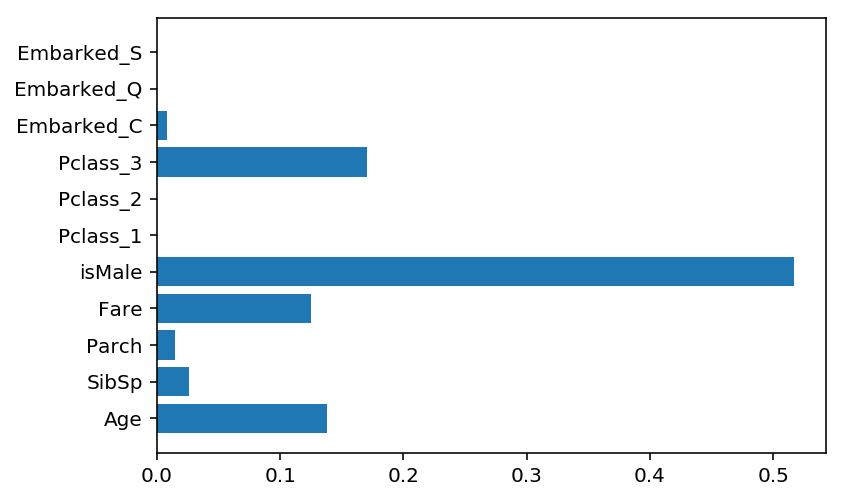

In [46]:
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X_train_imputed_scaled.columns)),X_train_imputed_scaled.columns)

Финальное предсказание и сабмит

In [47]:
clf.predict_proba(X_test_imputed_scaled)[:10]

array([[0.90985915, 0.09014085],
       [0.85714286, 0.14285714],
       [0.90985915, 0.09014085],
       [0.90985915, 0.09014085],
       [0.38181818, 0.61818182],
       [0.90985915, 0.09014085],
       [0.38181818, 0.61818182],
       [0.64393939, 0.35606061],
       [0.38181818, 0.61818182],
       [0.90985915, 0.09014085]])

In [48]:
predictions = clf.predict(X_test_imputed_scaled)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [49]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])

In [50]:
with open('submission.txt', 'w') as file:
    file.write(submussion)

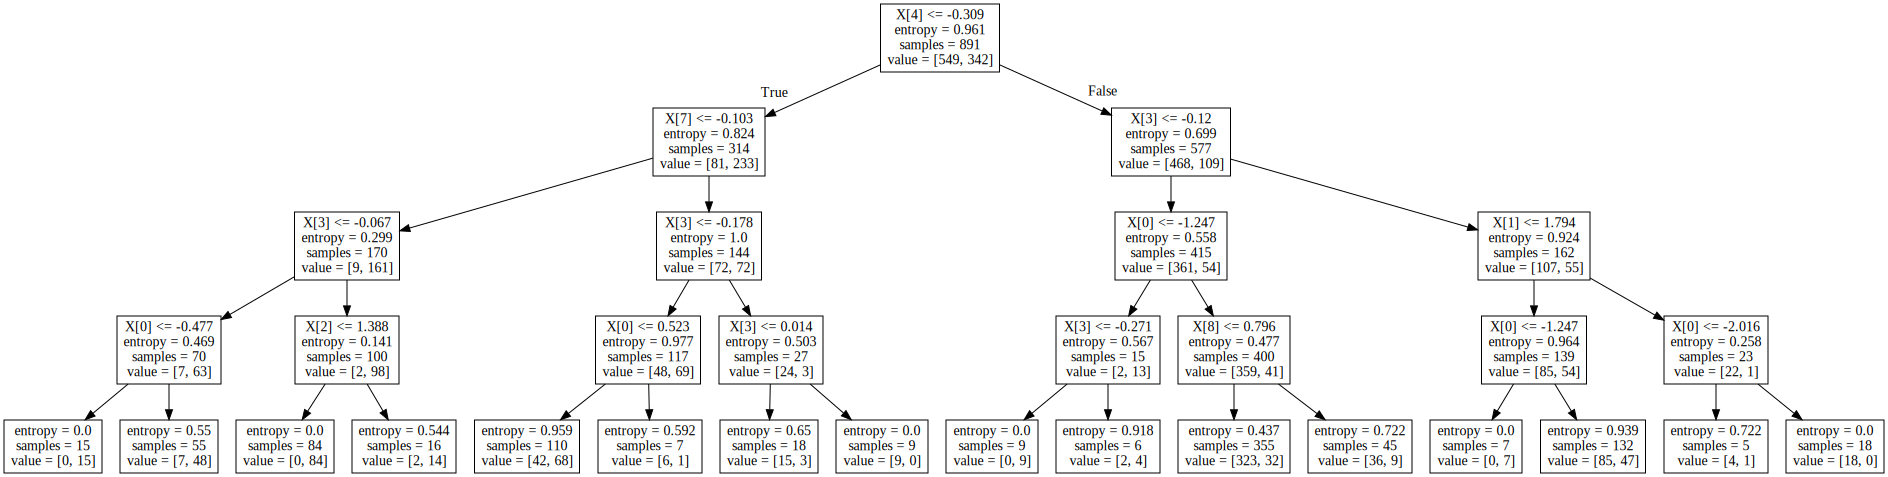

In [51]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [52]:
tree.export_graphviz(clf, out_file='tree.dot') 

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [53]:
from sklearn import metrics

In [54]:
def metrics_roc(y, y_pred):
    accuracy= metrics.accuracy_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    cf_mtrx = metrics.confusion_matrix(y, y_pred)
    TPR = [0, recall, 1]
    pr_metrics = [0, precision, 1]
    FPR = cf_mtrx[0][1]/(cf_mtrx[0][1]+cf_mtrx[1][1])
    FPR = [0, FPR, 1]
    ROC_AUC = metrics.auc(FPR, TPR)
    ROC_PRC = metrics.auc(pr_metrics, TPR)
    return ROC_AUC, ROC_PRC

In [55]:
ROC_AUC, ROC_PRC = metrics_roc(y_val, y_val_pred)

In [56]:
print('ROC_PRC {:f}'.format(ROC_PRC))

ROC_PRC 0.451933


In [57]:
print('ROC_AUC {:f}'.format(ROC_AUC))

ROC_AUC 0.745037
